# Data was obtained from Instacart at the following link:
https://www.instacart.com/datasets/grocery-shopping-2017
    “The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on <Feb 7, 2020>

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity 

%matplotlib inline

## Read In data
Note:Will ignore order_products__train as this is a split of the prior orders dataset used for machine learning model competitions

### Aisles 

In [48]:
aisles = pd.read_csv('data/aisles.csv')
print(aisles.shape)
aisles.head()

(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [49]:
# EDA on aisles
aisles.isnull().sum() # confirmed no null values

aisle_id    0
aisle       0
dtype: int64

In [50]:
aisles.dtypes

aisle_id     int64
aisle       object
dtype: object

### Departments

In [51]:
departments = pd.read_csv('data/departments.csv')

In [52]:
departments # noted department_id '21' is labeled 'missing'

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


### Products Table

In [53]:
products = pd.read_csv('data/products.csv')

In [54]:
print(f'The shape of the products dataframe is {products.shape}.')
print(f'There are {len(products)} products available to order from.')

products.head()

The shape of the products dataframe is (49688, 4).
There are 49688 products available to order from.


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [55]:
# want to merge departments and products dataframes on the department ids
prods_depts = pd.merge(products, departments, how='inner', on='department_id')

prods_depts.tail()

,product_id,product_name,aisle_id,department_id,department
49683,43769,Organic Pearled Barley,68,10,bulk
49684,45682,Organic Turkish Apricots,68,10,bulk
49685,46889,Organic Brown Basmati Rice,68,10,bulk
49686,47489,Organic Brown Jasmine Rice,68,10,bulk
49687,48778,"Fit Super A Juice, Cold Pressed, Carrot/Apple/...",18,10,bulk


In [56]:
print(f' The shape of the merged products/departments table is: {prods_depts.shape}.')
prods_depts.head()

 The shape of the merged products/departments table is: (49688, 5).


,product_id,product_name,aisle_id,department_id,department
0,1,Chocolate Sandwich Cookies,61,19,snacks
1,16,Mint Chocolate Flavored Syrup,103,19,snacks
2,25,Salted Caramel Lean Protein & Fiber Bar,3,19,snacks
3,32,Nacho Cheese White Bean Chips,107,19,snacks
4,41,Organic Sourdough Einkorn Crackers Rosemary,78,19,snacks


Merge products, depts & aisles:

In [57]:
products_depts_aisles = pd.merge(prods_depts, aisles, on='aisle_id', how='inner')

In [58]:
products_per_dept = products_depts_aisles.\
groupby('department')['product_id'].count().reset_index().sort_values(by='product_id', ascending=False)

In [59]:
products_per_dept

,department,product_id
17,personal care,6563
20,snacks,6264
16,pantry,5371
3,beverages,4365
10,frozen,4007
7,dairy eggs,3449
11,household,3085
6,canned goods,2092
9,dry goods pasta,1858
19,produce,1684


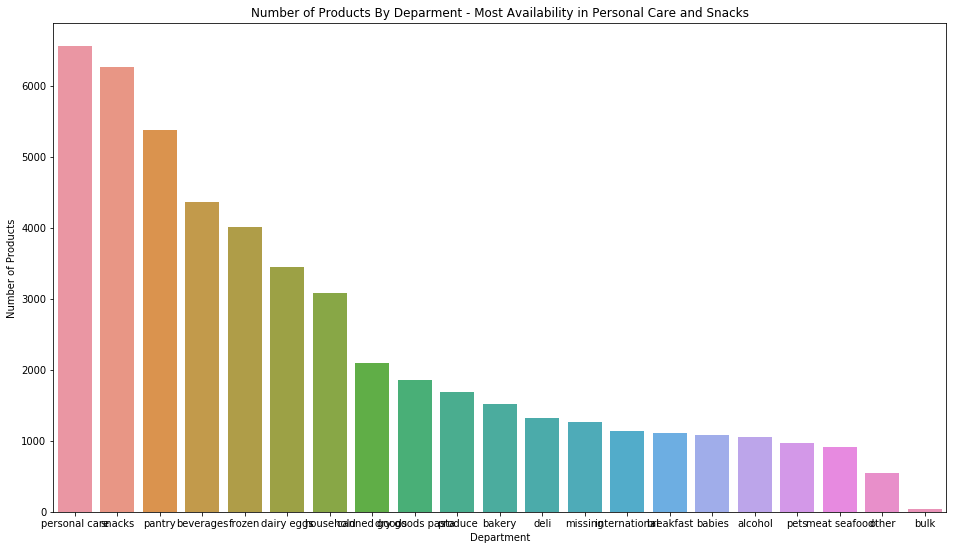

In [60]:
plt.figure(figsize=(16,9))
sns.barplot(products_per_dept['department'], products_per_dept['product_id'])
plt.ylabel('Number of Products')
plt.xlabel('Department')
plt.title('Number of Products By Deparment - Most Availability in Personal Care and Snacks');

### Prior Orders

In [61]:
prior_orders = pd.read_csv('data/order_products__prior.csv')
print(prior_orders.shape)
prior_orders.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [62]:
prior_orders.isnull().sum() # confirmed no null values

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [63]:
prior_orders.dtypes

order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtype: object

In [64]:
print(f'There are {len(prior_orders.order_id.unique())} unique orders in prior orders data set.')

There are 3214874 unique orders in prior orders data set.


In [65]:
prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [66]:
prods_depts.shape

(49688, 5)

In [67]:
## want to get a full view of the prior orders including products and departments
prior_orders_clean = prior_orders.merge(prods_depts, left_on='product_id', right_on='product_id', how='left')
print(prior_orders_clean.shape)
prior_orders_clean.head()

(32434489, 8)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,produce
2,2,9327,3,0,Garlic Powder,104,13,pantry
3,2,45918,4,1,Coconut Butter,19,13,pantry
4,2,30035,5,0,Natural Sweetener,17,13,pantry


In [68]:
## want to get a full view of the prior orders including products and departments
prior_orders_clean_ij = prior_orders.merge(prods_depts, left_on='product_id', right_on='product_id', how='inner')
print(prior_orders_clean_ij.shape)
prior_orders_clean_ij.head()

(32434489, 8)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs
1,26,33120,5,0,Organic Egg Whites,86,16,dairy eggs
2,120,33120,13,0,Organic Egg Whites,86,16,dairy eggs
3,327,33120,5,1,Organic Egg Whites,86,16,dairy eggs
4,390,33120,28,1,Organic Egg Whites,86,16,dairy eggs


In [69]:
prior_orders_clean.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
product_name         0
aisle_id             0
department_id        0
department           0
dtype: int64

In [70]:
# also want to have aisle data on the prior orders
prior_orders_clean = pd.merge(prior_orders_clean, aisles, how='inner', on='aisle_id')
print()
prior_orders_clean.head(15)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,eggs
1,22,23341,6,1,Large Grade AA Eggs,86,16,dairy eggs,eggs
2,25,6383,7,1,All Whites 100% Egg Whites,86,16,dairy eggs,eggs
3,26,33120,5,0,Organic Egg Whites,86,16,dairy eggs,eggs
4,55,11520,12,0,Large Alfresco Eggs,86,16,dairy eggs,eggs
5,56,11520,4,1,Large Alfresco Eggs,86,16,dairy eggs,eggs
6,67,46654,4,1,Organic Grade A Large Brown Eggs,86,16,dairy eggs,eggs
7,74,17902,5,1,Liquid Egg Whites,86,16,dairy eggs,eggs
8,77,36550,20,1,Organic Extra Large Grade AA Brown Eggs,86,16,dairy eggs,eggs
9,88,46654,15,1,Organic Grade A Large Brown Eggs,86,16,dairy eggs,eggs


In [71]:
prior_orders_clean.tail(15)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
32434474,3415356,2022,10,1,Brut Cuvee Sparkling Champagne,134,5,alcohol,specialty wines champagnes
32434475,3415443,10607,4,0,Prosecco,134,5,alcohol,specialty wines champagnes
32434476,3415715,10607,7,0,Prosecco,134,5,alcohol,specialty wines champagnes
32434477,3415775,8439,1,1,Sofia Pinot Noir Rosé Wine,134,5,alcohol,specialty wines champagnes
32434478,3416910,37923,5,1,Prosecco Sparkling Wine,134,5,alcohol,specialty wines champagnes
32434479,3417783,20195,24,0,Prosecco Treviso,134,5,alcohol,specialty wines champagnes
32434480,3417972,41274,1,0,Sayuri Junmai Nigori,134,5,alcohol,specialty wines champagnes
32434481,3418165,150,6,1,Brut Rosé,134,5,alcohol,specialty wines champagnes
32434482,3419535,4285,14,0,"Sangria, Tradicional, Fresh Citrus",134,5,alcohol,specialty wines champagnes
32434483,3419990,10607,3,1,Prosecco,134,5,alcohol,specialty wines champagnes


Per inspection of the data dictionary, the 'add_to_cart_order' series indicates the order by which the customer added a product to an order.
https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b

In [72]:
prior_orders_clean_df = prior_orders_clean.to_csv('data/prior_orders_cleaned_df.csv', index=False)

In [73]:
prior_orders_clean['reordered'].value_counts(normalize=True)

1    0.589697
0    0.410303
Name: reordered, dtype: float64

Based on the above, the 'reordered' column is a binary classification, returning 1 if the user has ordered the item before.

About 59% of the items in this set have been re-ordered, while the remaining 41% have not been.

In [74]:
print(prior_orders_clean.shape)
print(prior_orders.shape)

(32434489, 9)
(32434489, 4)


In [75]:
prior_orders_clean.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
product_name         0
aisle_id             0
department_id        0
department           0
aisle                0
dtype: int64

### EDA on prior_orders_clean

In [76]:
prior_orders_clean['department'].value_counts()

produce            9479291
dairy eggs         5414016
snacks             2887550
beverages          2690129
frozen             2236432
pantry             1875577
bakery             1176787
canned goods       1068058
deli               1051249
dry goods pasta     866627
household           738666
breakfast           709569
meat seafood        708931
personal care       447123
babies              423802
international       269253
alcohol             153696
pets                 97724
missing              69145
other                36291
bulk                 34573
Name: department, dtype: int64

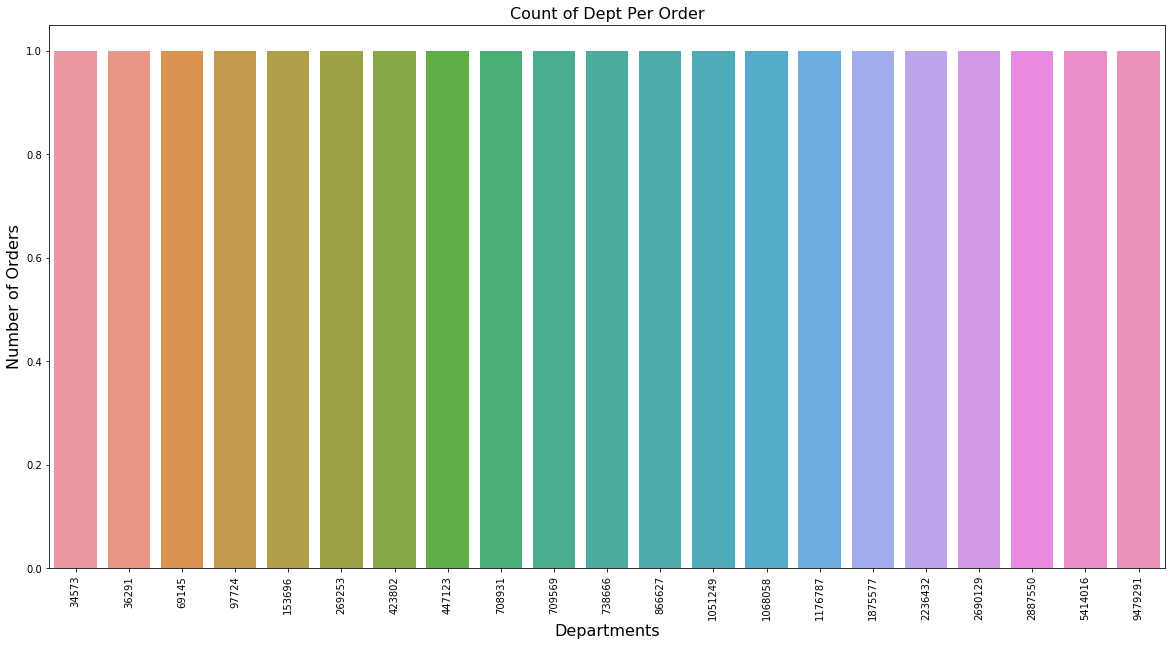

In [77]:
orders_by_dept = prior_orders_clean.groupby('department')['order_id'].count().value_counts()

plt.figure(figsize=(20,10))
sns.barplot(x=orders_by_dept.index, y=orders_by_dept.values)
plt.title('Count of Dept Per Order', fontsize=16)
plt.ylabel('Number of Orders', fontsize=16)
plt.xlabel('Departments', fontsize=16)
plt.xticks(rotation='vertical');

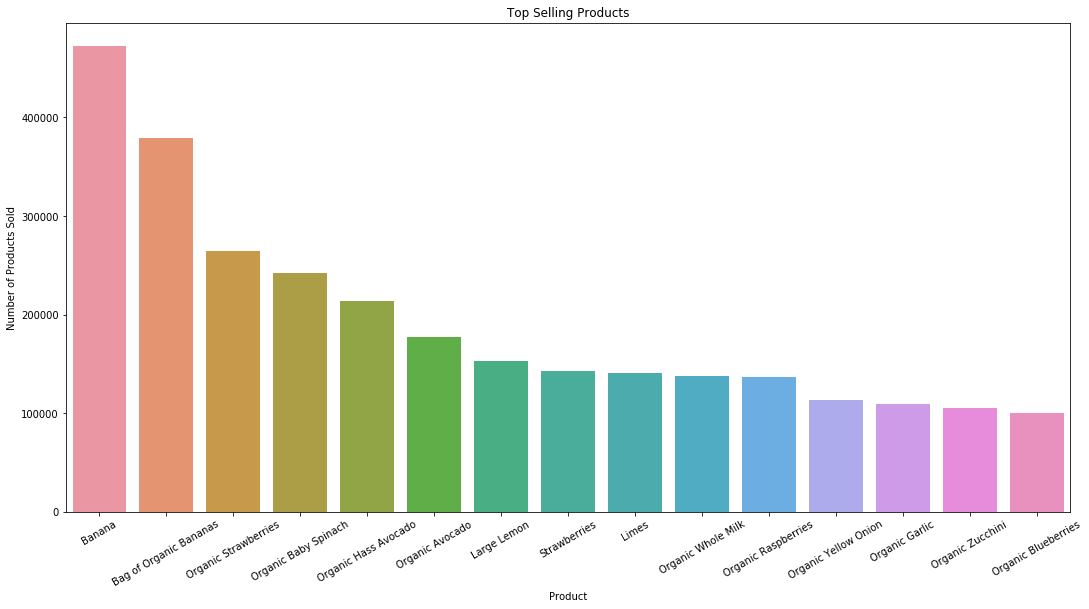

In [78]:
plt.figure(figsize=(18,9))
sns.barplot(top_products['product_name'], top_products['purchase_count'])
plt.ylabel('Number of Products Sold')
plt.xlabel('Product')
plt.title('Top Selling Products')
plt.xticks(rotation=30);

In [79]:
top_products = prior_orders_clean.product_name.value_counts(ascending=False).reset_index().head(15)

top_products.columns = ['product_name', 'purchase_count']
top_products

,product_name,purchase_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


In [80]:
## top aisles:
top_aisles = prior_orders_clean.aisle.value_counts(ascending=False).reset_index().head(15)

top_aisles.columns = ['aisle', 'purchase_count']
top_aisles

,aisle,purchase_count
0,fresh fruits,3642188
1,fresh vegetables,3418021
2,packaged vegetables fruits,1765313
3,yogurt,1452343
4,packaged cheese,979763
5,milk,891015
6,water seltzer sparkling water,841533
7,chips pretzels,722470
8,soy lactosefree,638253
9,bread,584834


In [33]:
## top departments:
top_departments = prior_orders_clean.department.value_counts(ascending=False).reset_index().head(20)

top_departments.columns = ['departments', 'purchase_count']
top_departments

,departments,purchase_count
0,produce,9479291
1,dairy eggs,5414016
2,snacks,2887550
3,beverages,2690129
4,frozen,2236432
5,pantry,1875577
6,bakery,1176787
7,canned goods,1068058
8,deli,1051249
9,dry goods pasta,866627


### Reading in the orders table

In [34]:
orders = pd.read_csv('data/orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [35]:
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [36]:
day_count = [i for i in range(0, 32)]

In [37]:
orders.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')

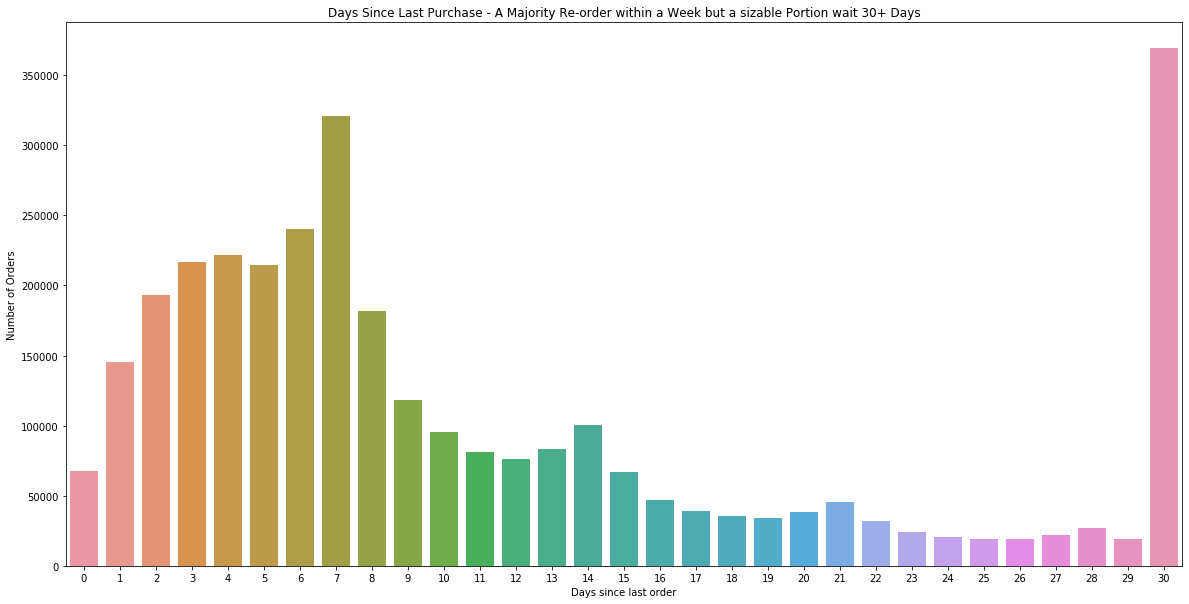

In [38]:
plt.figure(figsize=(20,10))
sns.countplot(x=orders.days_since_prior_order)

plt.title('Days Since Last Purchase - A Majority Re-order within a Week but a sizable Portion wait 30+ Days')
plt.xlabel('Days since last order')
plt.ylabel('Number of Orders')
plt.xticks(np.arange(31), day_count);

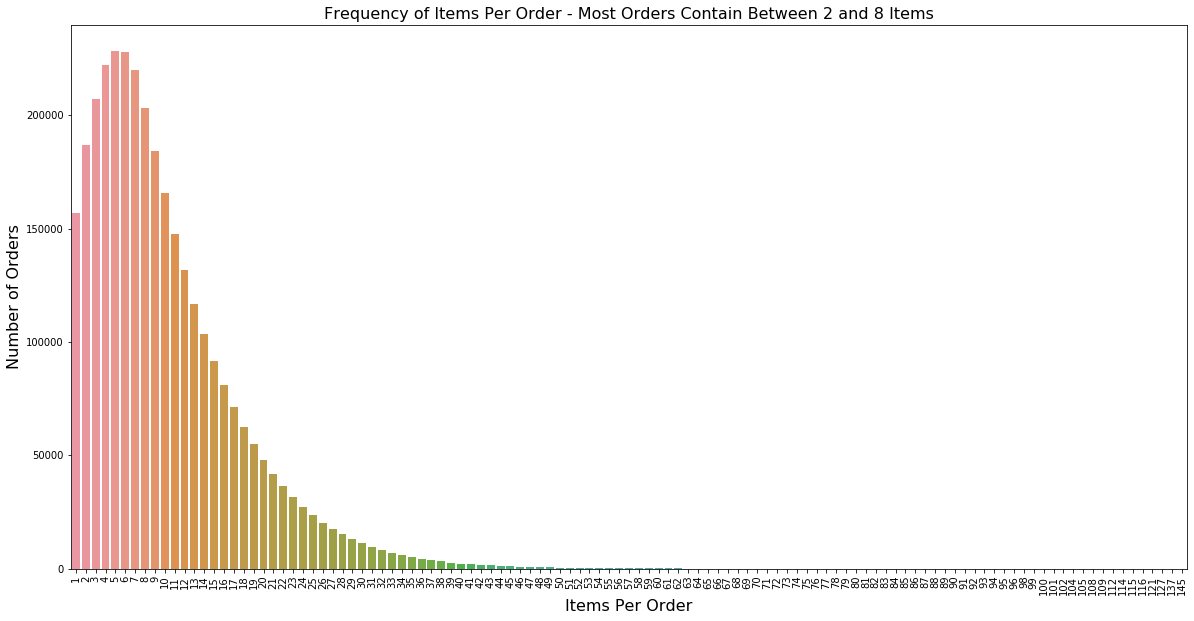

In [39]:
# items per order
plt.figure(figsize=(20,10))
order_frequency = prior_orders_clean.groupby('order_id')['product_id'].count().value_counts()
sns.barplot(x=order_frequency.index, y=order_frequency.values)
plt.title('Frequency of Items Per Order - Most Orders Contain Between 2 and 8 Items', fontsize=16)
plt.ylabel('Number of Orders', fontsize=16)
plt.xlabel('Items Per Order', fontsize=16)
plt.xticks(rotation='vertical');

In [40]:
## Some summary statistics

print(f'There are {prior_orders_clean.shape[0]} items previously ordered.')
print(f'There were {len(prior_orders_clean.order_id.unique())} orders previously placed.')
print(f'There were {len(prior_orders_clean.product_id.unique())} unique products previously ordered.')

There are 32434489 items previously ordered.
There were 3214874 orders previously placed.
There were 49677 unique products previously ordered.


In [41]:
prior_orders_clean.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,eggs
1,22,23341,6,1,Large Grade AA Eggs,86,16,dairy eggs,eggs
2,25,6383,7,1,All Whites 100% Egg Whites,86,16,dairy eggs,eggs
3,26,33120,5,0,Organic Egg Whites,86,16,dairy eggs,eggs
4,55,11520,12,0,Large Alfresco Eggs,86,16,dairy eggs,eggs


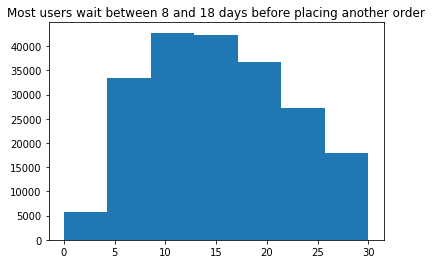

In [42]:
days_since_prior = orders.groupby('user_id')['days_since_prior_order'].mean()

plt.hist(days_since_prior, bins = 7);
plt.title('Most users wait between 8 and 18 days before placing another order');

In [43]:
prior_orders_clean[prior_orders_clean['order_id'] == 473747]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
4800696,473747,30450,5,0,Creamy Almond Butter,88,13,pantry,spreads
18376445,473747,25133,4,0,Organic String Cheese,21,16,dairy eggs,packaged cheese
24860231,473747,196,1,1,Soda,77,7,beverages,soft drinks
26586831,473747,12427,2,1,Original Beef Jerky,23,19,snacks,popcorn jerky
27263766,473747,10258,3,1,Pistachios,117,19,snacks,nuts seeds dried fruit


In [44]:
orders = pd.read_csv('data/orders.csv')

In [45]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


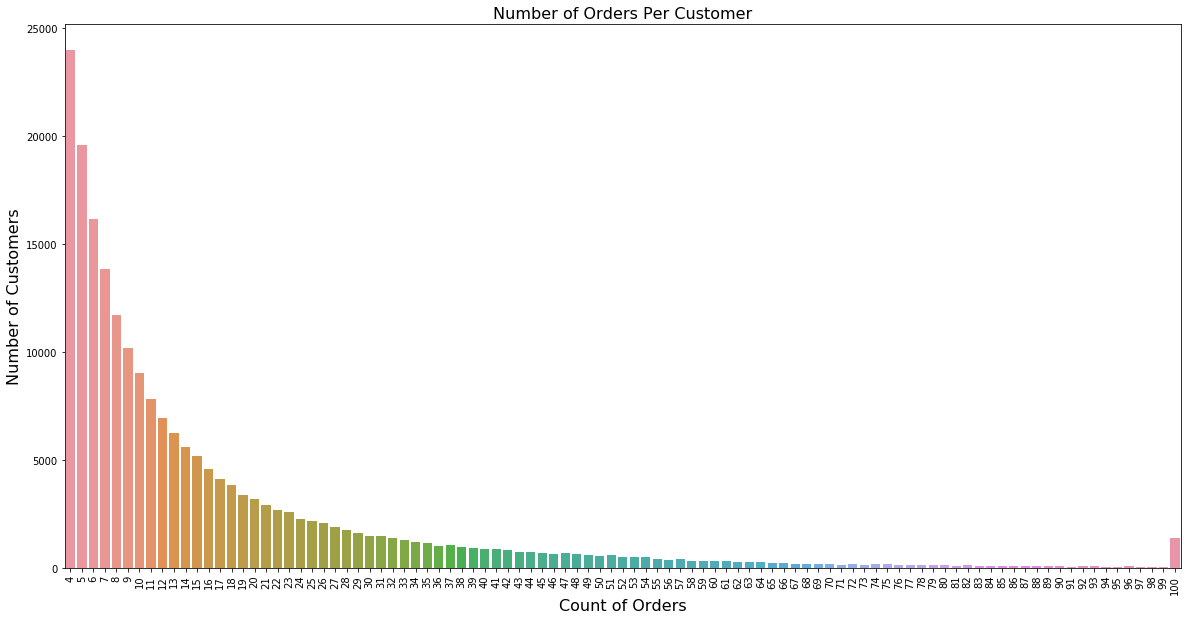

In [46]:
orders_per_customer = orders.groupby('user_id')['order_number'].count().value_counts()

plt.figure(figsize=(20,10))
sns.barplot(x=orders_per_customer.index, y=orders_per_customer.values)
plt.title('Number of Orders Per Customer', fontsize=16)
plt.ylabel('Number of Customers', fontsize=16)
plt.xlabel('Count of Orders', fontsize=16)
plt.xticks(rotation='vertical');

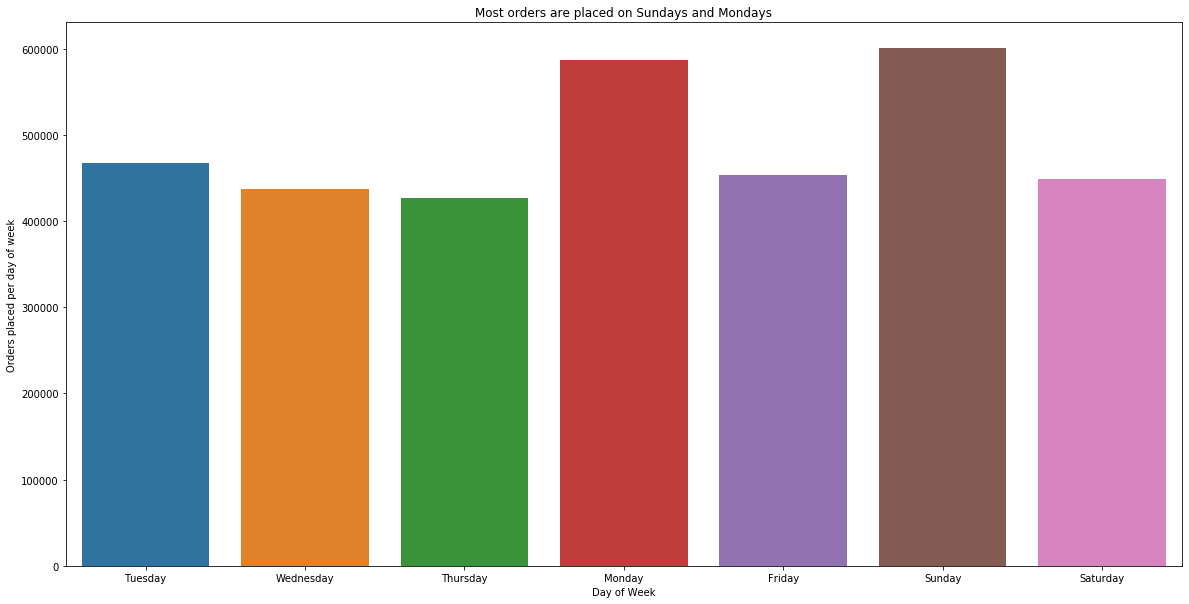

In [47]:
orders['order_dow'] = orders['order_dow'].map({0:'Sunday', 
                        1: 'Monday', 
                        2: 'Tuesday', 
                        3: 'Wednesday', 
                        4: 'Thursday',
                        5: 'Friday', 
                        6: 'Saturday'})
plt.figure(figsize=(20,10))

sns.countplot(x=orders['order_dow'])
plt.ylabel('Orders placed per day of week')
plt.xlabel('Day of Week')
plt.title('Most orders are placed on Sundays and Mondays');

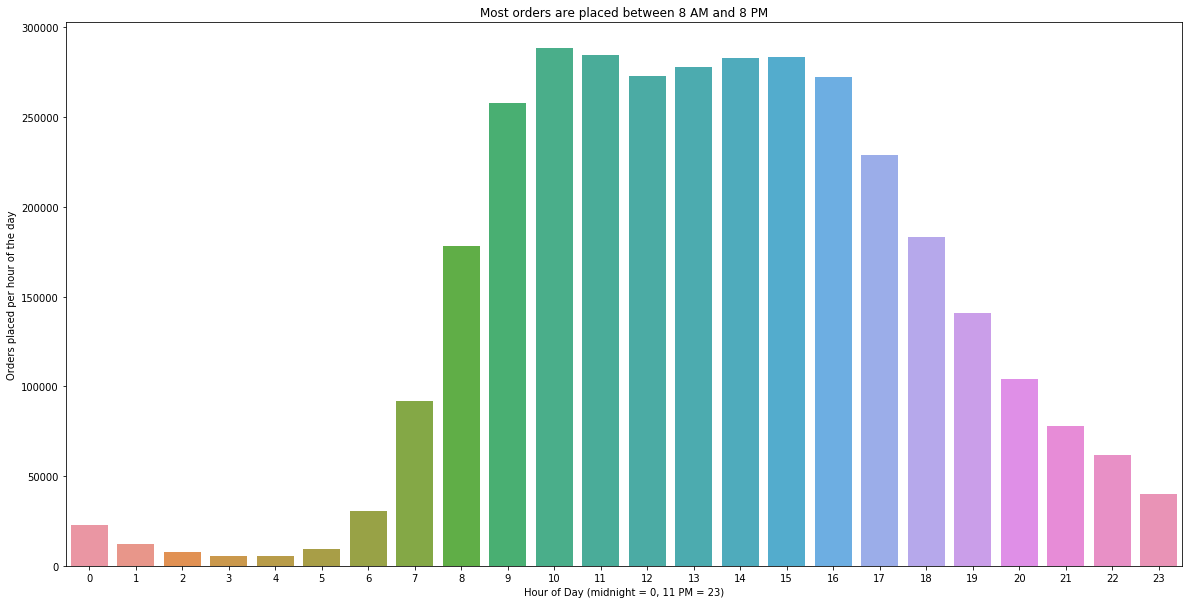

In [48]:
plt.figure(figsize=(20,10))

sns.countplot(x=orders['order_hour_of_day'])
plt.ylabel('Orders placed per hour of the day')
plt.xlabel('Hour of Day (midnight = 0, 11 PM = 23)')
plt.title('Most orders are placed between 8 AM and 8 PM');

In [49]:
orders.isnull().sum()
# days since prior order contains null values for 206,209 observations, likely indicating a prior order has not occurred.


order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [50]:
orders.fillna(0, inplace=True)

In [51]:
# Confirmed that 0 was imputed for the missing values
orders.isnull().sum()


order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

Will use the full 'orders' table for analysis. Inspection of the 'eval_set' series reveals that it was split into the prior, train and test set for machine learning competitions

In [52]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

### Re-ordering Ratios?

In [53]:
prior_orders_clean.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,eggs
1,22,23341,6,1,Large Grade AA Eggs,86,16,dairy eggs,eggs
2,25,6383,7,1,All Whites 100% Egg Whites,86,16,dairy eggs,eggs
3,26,33120,5,0,Organic Egg Whites,86,16,dairy eggs,eggs
4,55,11520,12,0,Large Alfresco Eggs,86,16,dairy eggs,eggs


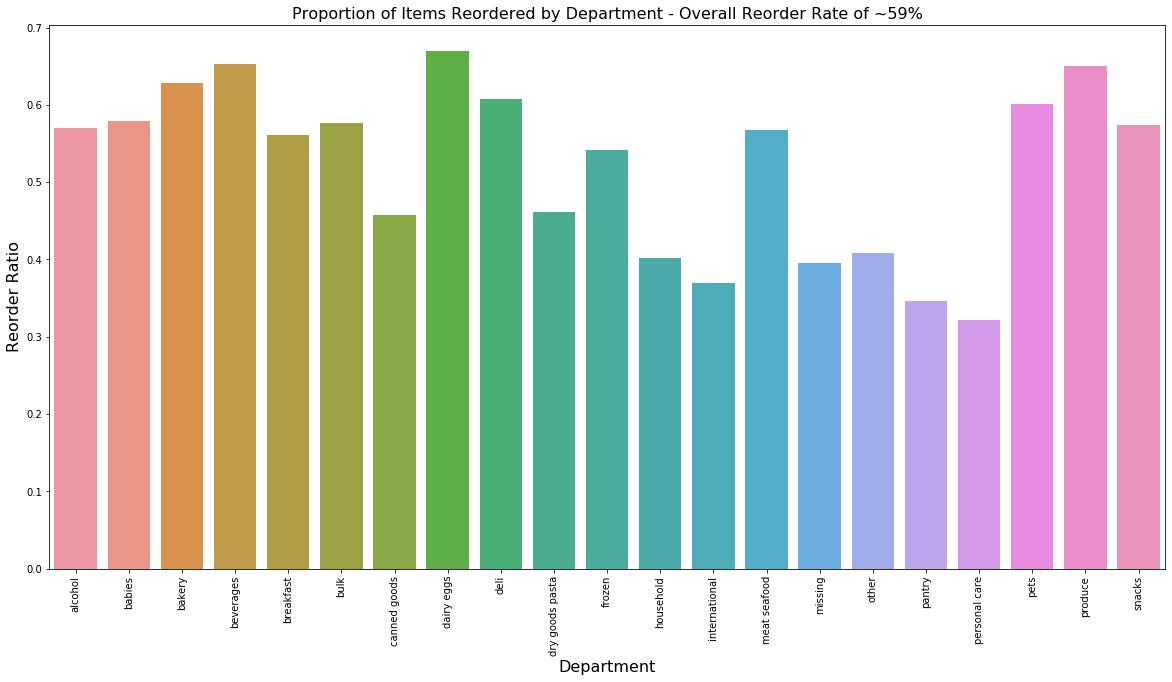

In [54]:
dept_reorder_ratio = prior_orders_clean.groupby('department')['reordered'].mean().reset_index()


plt.figure(figsize=(20,10))
sns.barplot(x=dept_reorder_ratio['department'], y=dept_reorder_ratio['reordered'])
plt.title('Proportion of Items Reordered by Department - Overall Reorder Rate of ~59%', fontsize=16)
plt.ylabel('Reorder Ratio', fontsize=16)
plt.xlabel('Department', fontsize=16)
plt.xticks(rotation='vertical');

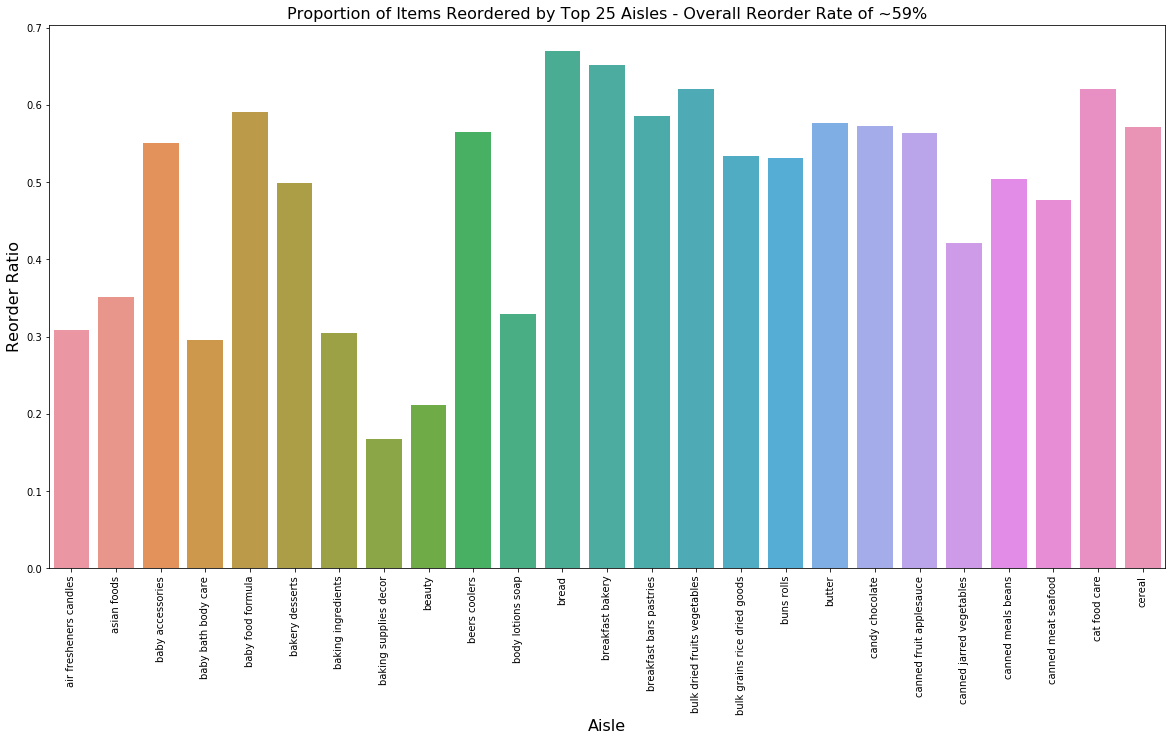

In [55]:
aisles_reorder_ratio = prior_orders_clean.groupby('aisle')['reordered'].mean().reset_index()[0:25]


plt.figure(figsize=(20,10))
sns.barplot(x=aisles_reorder_ratio['aisle'], y=aisles_reorder_ratio['reordered'])
plt.title('Proportion of Items Reordered by Top 25 Aisles - Overall Reorder Rate of ~59%', fontsize=16)
plt.ylabel('Reorder Ratio', fontsize=16)
plt.xlabel('Aisle', fontsize=16)
plt.xticks(rotation='vertical');

In [56]:
print(prior_orders_clean.shape)
prior_orders_clean.head()

(32434489, 9)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,eggs
1,22,23341,6,1,Large Grade AA Eggs,86,16,dairy eggs,eggs
2,25,6383,7,1,All Whites 100% Egg Whites,86,16,dairy eggs,eggs
3,26,33120,5,0,Organic Egg Whites,86,16,dairy eggs,eggs
4,55,11520,12,0,Large Alfresco Eggs,86,16,dairy eggs,eggs


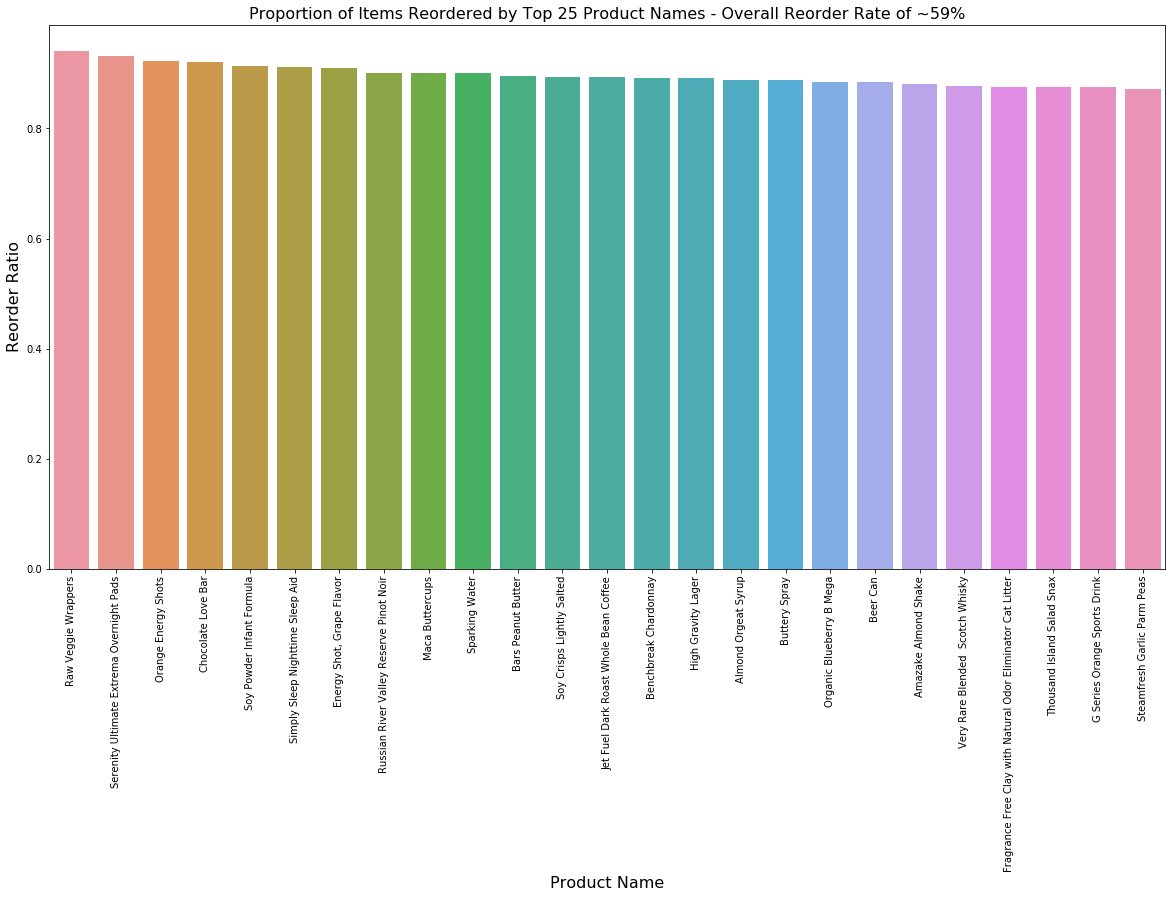

In [57]:
products_reorder_ratio = \
prior_orders_clean.groupby('product_name')['reordered'].mean().reset_index().sort_values(by=['reordered'], ascending=False)[0:25]


plt.figure(figsize=(20,10))
sns.barplot(x=products_reorder_ratio['product_name'], y=products_reorder_ratio['reordered'])
plt.title('Proportion of Items Reordered by Top 25 Product Names - Overall Reorder Rate of ~59%', fontsize=16)
plt.ylabel('Reorder Ratio', fontsize=16)
plt.xlabel('Product Name', fontsize=16)
plt.xticks(rotation='vertical');

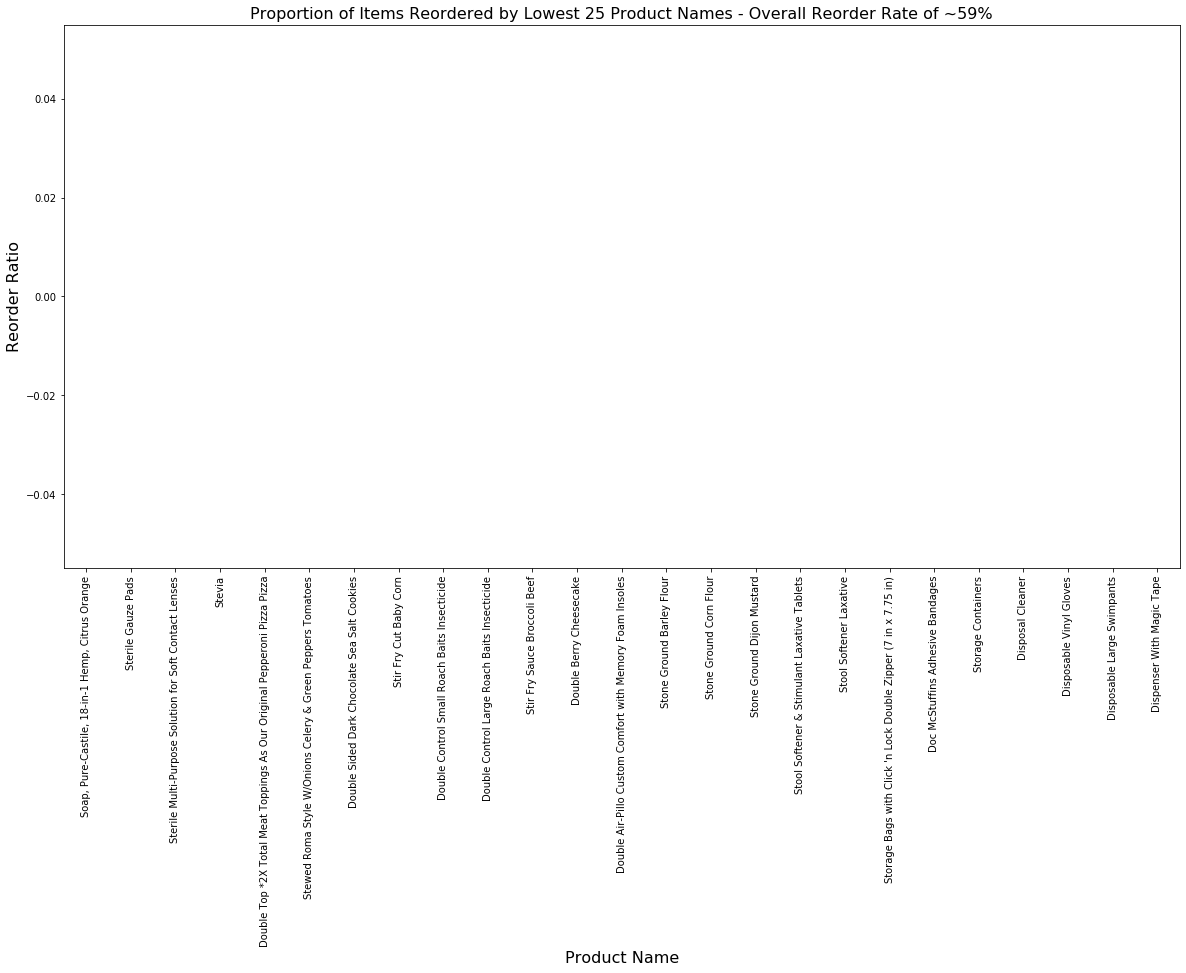

In [58]:
products_reorder_ratio = \
prior_orders_clean.groupby('product_name')['reordered'].mean().reset_index().sort_values(by=['reordered'], ascending=True)[0:25]


plt.figure(figsize=(20,10))
sns.barplot(x=products_reorder_ratio['product_name'], y=products_reorder_ratio['reordered'])
plt.title('Proportion of Items Reordered by Lowest 25 Product Names - Overall Reorder Rate of ~59%', fontsize=16)
plt.ylabel('Reorder Ratio', fontsize=16)
plt.xlabel('Product Name', fontsize=16)
plt.xticks(rotation='vertical');

## Creating one master dataframe for analysis

In [59]:
print(orders.shape)
orders.head()

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,Tuesday,8,0.0
1,2398795,1,prior,2,Wednesday,7,15.0
2,473747,1,prior,3,Wednesday,12,21.0
3,2254736,1,prior,4,Thursday,7,29.0
4,431534,1,prior,5,Thursday,15,28.0


In [60]:
print(prior_orders_clean.shape)
prior_orders_clean.head()

(32434489, 9)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,eggs
1,22,23341,6,1,Large Grade AA Eggs,86,16,dairy eggs,eggs
2,25,6383,7,1,All Whites 100% Egg Whites,86,16,dairy eggs,eggs
3,26,33120,5,0,Organic Egg Whites,86,16,dairy eggs,eggs
4,55,11520,12,0,Large Alfresco Eggs,86,16,dairy eggs,eggs


In [61]:
master_df = pd.merge(prior_orders_clean, orders, on='order_id', how='inner')
print(master_df.shape)
master_df.head()


(32434489, 15)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,eggs,202279,prior,3,Friday,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,produce,fresh vegetables,202279,prior,3,Friday,9,8.0
2,2,17794,6,1,Carrots,83,4,produce,fresh vegetables,202279,prior,3,Friday,9,8.0
3,2,9327,3,0,Garlic Powder,104,13,pantry,spices seasonings,202279,prior,3,Friday,9,8.0
4,2,45918,4,1,Coconut Butter,19,13,pantry,oils vinegars,202279,prior,3,Friday,9,8.0


In [70]:
# export master_df to csv
master_df_for_modeling = master_df.to_csv('data/master_df_for_modeling.csv', index=False)

# Building A Recommender System Using Cosine Similarity

In [62]:
master_df['reordered'].value_counts()

1    19126536
0    13307953
Name: reordered, dtype: int64

#### get a filtered dataframe for only items that have been re-ordered

In [63]:
master_reorders = master_df[master_df['reordered'] == 1]

### Want to identify re-orders with high volumes in case they potentially skew the data

In [64]:
master_reorders['volume_higher'] = (master_reorders['product_id'].value_counts().sort_values(ascending=False) > 1)

/Users/nicolasavega/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [65]:
master_reorders['volume_higher'].value_counts()

True     25731
False     1761
Name: volume_higher, dtype: int64

In [66]:
reorders = master_reorders[master_reorders['reordered'] == 1]

In [67]:
reorders.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,volume_higher
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,eggs,202279,prior,3,Friday,9,8.0,NaN
1,2,28985,2,1,Michigan Organic Kale,83,4,produce,fresh vegetables,202279,prior,3,Friday,9,8.0,True
2,2,17794,6,1,Carrots,83,4,produce,fresh vegetables,202279,prior,3,Friday,9,8.0,True
4,2,45918,4,1,Coconut Butter,19,13,pantry,oils vinegars,202279,prior,3,Friday,9,8.0,True
6,2,40141,7,1,Original Unflavored Gelatine Mix,105,13,pantry,doughs gelatins bake mixes,202279,prior,3,Friday,9,8.0,True


In [68]:
high_volume = reorders[reorders['volume_higher'] == True]


Creating a dataframe of high volume users that we can unstack and have users as our rows and products as our columns

In [2]:
high_volume_users = high_volume.groupby(['user_id', 'product_name']).size().sort_values(ascending=False).unstack().fillna(0)

NameError: name 'high_volume' is not defined

In [89]:
high_volume['reordered'].value_counts()

1    25731
Name: reordered, dtype: int64

In [ ]:
pivot = master_df.pivot_table(index='user_id', columns='product_name', values='reordered')

In [ ]:
pivot

In [82]:
high_volume.dtypes

order_id                    int64
product_id                  int64
add_to_cart_order           int64
reordered                   int64
product_name               object
aisle_id                    int64
department_id               int64
department                 object
aisle                      object
user_id                     int64
eval_set                   object
order_number                int64
order_dow                  object
order_hour_of_day           int64
days_since_prior_order    float64
volume_higher              object
dtype: object

In [1]:
high_volume_users

NameError: name 'high_volume_users' is not defined

In [26]:
reorders = prior_orders_clean[prior_orders_clean['reordered'] == 1]

In [27]:
reorders

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,produce
3,2,45918,4,1,Coconut Butter,19,13,pantry
5,2,17794,6,1,Carrots,83,4,produce
6,2,40141,7,1,Original Unflavored Gelatine Mix,105,13,pantry
...,...,...,...,...,...,...,...,...
32434476,3421082,32700,5,1,Original Whipped Cream,53,16,dairy eggs
32434482,3421083,18176,4,1,Organic Strawberry Yogurt & Fruit Snack,92,18,babies
32434484,3421083,39678,6,1,Free & Clear Natural Dishwasher Detergent,74,17,household
32434487,3421083,24852,9,1,Banana,24,4,produce


## Reading in orders

In [35]:
orders = pd.read_csv('./data/orders.csv')

In [36]:
orders2 = orders[['order_id', 'user_id']]

In [37]:
user_orders = reorders.merge(orders2, on='order_id')

In [39]:
user_orders['high_volume'] = (user_orders['product_id'].value_counts().sort_values(ascending=False) > 1)

In [41]:
user_orders.shape

(19126536, 10)

In [42]:
high_volume = user_orders[user_orders['high_volume'] == True]

In [43]:
high_volume.shape

(42377, 10)

In [44]:
high_volume.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,user_id,high_volume
1,2,28985,2,1,Michigan Organic Kale,83,4,produce,202279,True
2,2,45918,4,1,Coconut Butter,19,13,pantry,202279,True
3,2,17794,6,1,Carrots,83,4,produce,202279,True
4,2,40141,7,1,Original Unflavored Gelatine Mix,105,13,pantry,202279,True
5,2,1819,8,1,All Natural No Stir Creamy Almond Butter,88,13,pantry,202279,True


In [45]:
high_volume['reordered'].value_counts()

1    42377
Name: reordered, dtype: int64

In [46]:
high_volume_users = high_volume.groupby(['user_id', 'product_name']).size().sort_values(ascending=False).unstack().fillna(0)

In [47]:
high_volume_users

product_name,0% Fat Blueberry Greek Yogurt,0% Fat Free Organic Milk,0% Fat Organic Greek Vanilla Yogurt,0% Greek Strained Yogurt,0% Greek Yogurt Black Cherry on the Bottom,"0% Greek, Blueberry on the Bottom Yogurt",0% Milkfat Greek Yogurt Honey,1 % Lowfat Milk,1 Apple + 1 Mango Fruit Bar,1 Apple + 1 Pear Fruit Bar,...,"Zucchini, Spinach & Banana Blend Veggies On-The-Go Stage 2 (6 Months and Up)",from Concentrate Mango Nectar,in Gravy with Carrots Peas & Corn Mashed Potatoes & Meatloaf Nuggets,of Hanover 100 Calorie Pretzels Mini,smartwater® Electrolyte Enhanced Water,vitaminwater® XXX Acai Blueberry Pomegranate,with Crispy Almonds Cereal,with Olive Oil Mayonnaise Dressing,with Xylitol Cinnamon 18 Sticks Sugar Free Gum,with Xylitol Minty Sweet Twist 18 Sticks Sugar Free Gum
user_id,,,,,,,,,,,,,,,,,,,,,
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
recommender = pairwise_distances(high_volume_users, metric='cosine')

In [52]:
recommender.shape

(6862, 6862)

In [57]:
recommender_df = pd.DataFrame(recommender, columns=high_volume_users.index, index=high_volume_users.index)
recommender_df

user_id,27,66,90,150,155,206,208,214,222,382,...,205908,205943,205970,205990,206043,206082,206105,206158,206162,206206
user_id,,,,,,,,,,,,,,,,,,,,,
27,0.0,1.0,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.000000,0.823223,1.0,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.0
66,1.0,0.0,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.0
90,1.0,1.0,1.110223e-16,1.000000e+00,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.0
150,1.0,1.0,1.000000e+00,1.110223e-16,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.0
155,1.0,1.0,1.000000e+00,1.000000e+00,0.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206082,1.0,1.0,1.000000e+00,1.000000e+00,1.0,1.0,1.0,0.903775,1.0,1.0,...,1.0,0.833333,1.000000,1.0,1.0,0.0,1.0,1.000000e+00,1.000000e+00,1.0
206105,1.0,1.0,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.000000,1.000000,1.0,1.0,1.0,0.0,1.000000e+00,1.000000e+00,1.0
206158,1.0,1.0,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,2.220446e-16,1.000000e+00,1.0


In [61]:
recommender = cosine_similarity(high_volume_users)

In [62]:
recommender_df = pd.DataFrame(recommender, columns=high_volume_users.index, index=high_volume_users.index)
recommender_df

user_id,27,66,90,150,155,206,208,214,222,382,...,205908,205943,205970,205990,206043,206082,206105,206158,206162,206206
user_id,,,,,,,,,,,,,,,,,,,,,
27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.176777,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.096225,0.0,0.0,...,0.0,0.166667,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
206105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
206158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [60]:
cosine_dists = pd.DataFrame(cosine_similarity(high_volume_users),index=high_volume_users.index, columns=high_volume_users.index)
cosine_dists.head()

user_id,27,66,90,150,155,206,208,214,222,382,...,205908,205943,205970,205990,206043,206082,206105,206158,206162,206206
user_id,,,,,,,,,,,,,,,,,,,,,
27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.176777,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# function to enter a user_id and return a list of 10 recommended items
def product_recommender(user_id):
    user = high_volume.groupby(['user_id','product_name']).size().sort_values(ascending=False).unstack().fillna(0)
    user_similiartiy = pd.DataFrame(cosine_similarity(user), index=user.index, columns=user.index)

    products = high_volume.groupby(['product_name','user_id']).size().sort_values(ascending=False).unstack().fillna(0)
    
    recommended = pd.Series(np.dot(products.values,cosine_dists[user_id]), index=products.index)
    return recommended.sort_values(ascending=False)[0:11]

In [64]:
product_recommender(155)

product_name
100% Raw Coconut Water                 10.229165
Organic Egg Whites                      5.365468
Organic Lactose Free 1% Lowfat Milk     3.261439
Roasted Turkey Breast                   3.195634
Bag of Organic Bananas                  3.140098
Banana                                  2.845792
Organic Hass Avocado                    2.373692
Sesame Seaweed Salad                    2.161575
Organic Baby Spinach                    2.113084
Organic Strawberries                    2.063091
Organic Edamame                         1.621596
dtype: float64

In [66]:
product_recommender(206206)

product_name
Large Alfresco Eggs                   12.796436
Organic Whole Cashews                  5.056260
Bag of Organic Bananas                 4.160990
Organic Hass Avocado                   1.732008
Organic Baby Spinach                   1.705448
Organic Avocado                        1.519972
Banana                                 1.401888
Organic Granny Smith Apple             1.201822
Gluten Free Apple Cinnamon Waffles     1.138675
Potato Chips Sea Salt & Vinegar        1.000000
Organic Gala Apples                    0.861548
dtype: float64

In [65]:
cosine_dists.tail(12)

user_id,27,66,90,150,155,206,208,214,222,382,...,205908,205943,205970,205990,206043,206082,206105,206158,206162,206206
user_id,,,,,,,,,,,,,,,,,,,,,
205794,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0
205888,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0
205908,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,1.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0
205943,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,1.000000,0.0,0.25,0.0,0.166667,0.0,0.0,0.0,0.0
205970,0.176777,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,1.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0
205990,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.250000,0.0,1.00,0.0,0.000000,0.0,0.0,0.0,0.0
206043,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.00,1.0,0.000000,0.0,0.0,0.0,0.0
206082,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.096225,0.0,0.0,...,0.0,0.166667,0.0,0.00,0.0,1.000000,0.0,0.0,0.0,0.0
206105,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.00,0.0,0.000000,1.0,0.0,0.0,0.0


In [67]:
## Evaluate the recommender

In [72]:
users = high_volume.user_id.unique().tolist()

# calculate recall for 2500 users
def recommender_quality():
    recs = []
    for user in sorted(users)[:1000]:
        recommendations = product_recommender(user)
        top_20_products = [user_id == user].product_name.value_counts().head(20)
    
        recommendations_list = recommendations.index.tolist()
        top_20_items_list = top_20_products.index.tolist()
    
        res.append((len(set(recommendations_list) & set(top_20_items_list)))/5)
    return np.mean(res)
# get metric for the :1000 users
recommender_quality


<function __main__.recommender_quality()>

In [93]:
type(recommender_quality)

function

In [77]:
users = high_volume.user_id.unique().tolist()

In [79]:
len(users)

6862

## Using LightFM

In [95]:
from scipy.sparse import coo_matrix # for constructing sparse matrix
# lightfm 
from lightfm import LightFM # model
from lightfm.evaluation import auc_score
# timing
import time

 However, in the retail case, we can’t take an explicit rating from the historical data. In this case, implicitly, I take into account the “number of purchases” as the rating. If a customer A bought product B 10 times, then we can say customer A rated product B with rating 10. You can also take into account binary ratings where 1 refers to customer A had bought or 0 as had never bought product B. The user-item interaction matrix represents the collaborative filtering contribution to the model.

In [97]:
## need to remove aisles where the value is listed as 'other' and departments listed as missing

In [102]:
master_df

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,pantry,202279,prior,3,5,9,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,Free & Clear Natural Dishwasher Detergent,74,17,household,25247,prior,24,2,6,21.0
32434485,3421083,11352,7,0,Organic Mini Sandwich Crackers Peanut Butter,78,19,snacks,25247,prior,24,2,6,21.0
32434486,3421083,4600,8,0,All Natural French Toast Sticks,52,1,frozen,25247,prior,24,2,6,21.0
32434487,3421083,24852,9,1,Banana,24,4,produce,25247,prior,24,2,6,21.0


In [ ]:
departments = departments[departments["department"].apply(lambda x: x != "missing" and x != "other")]

In [107]:
# aisle_id 100 is the missing aisle that needs to be dropped
aisles[aisles['aisle'] == 'missing']

,aisle_id,aisle
99,100,missing


In [104]:
master_df = master_df[master_df['department'].apply(lambda x: x != 'missing' and x!= 'other')]

In [106]:
master_df.shape

(32329053, 14)

In [111]:
master_df.dtypes

order_id                    int64
product_id                  int64
add_to_cart_order           int64
reordered                   int64
product_name               object
aisle_id                    int64
department_id               int64
department                 object
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

In [114]:
master_df = master_df.merge(aisles, on='aisle_id')

In [115]:
master_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,202279,prior,3,5,9,8.0,eggs
1,22,23341,6,1,Large Grade AA Eggs,86,16,dairy eggs,30822,prior,25,1,8,12.0,eggs
2,25,6383,7,1,All Whites 100% Egg Whites,86,16,dairy eggs,59897,prior,19,6,10,25.0,eggs
3,26,33120,5,0,Organic Egg Whites,86,16,dairy eggs,153404,prior,2,0,16,7.0,eggs
4,55,11520,12,0,Large Alfresco Eggs,86,16,dairy eggs,127522,prior,8,4,14,5.0,eggs


In [118]:
master_df = master_df[master_df['aisle'].apply(lambda x: x != 'missing' and x!= 'other')]

In [119]:
master_df.shape

(32329053, 15)

LightFM can only read a sparse coo matrix. This can be constructed using the coo_matrix from scipy.sparse and the product_id can be converted to the index.

build the user-item interaction matrix with converted user_id into index representing the row of the matrix and into indexes as the column. And also not forgetting about creating dictionary mappings for user_id to index, index to user_id, item_id to index, and index to item_id.

In [120]:
## get a user list
def getting_users(df, user_col):
    # will create a list of users from the dataframe
    return np.sort(df[user_col].unique())

In [141]:
def getting_items(df, item_col):
    items = df[item_col].unique()
    # will create a list of items from the dataframe
    return items

In [122]:
def getting_features(aisle_df, department_df, aisle_name_col, department_name_col):
    
    aisle = aisle_df[aisle_name_col]
    department = department_df[department_name_col]
    
    return pd.concat([aisle, department], ignore_index = True).unique()


In [123]:
def map_ids(users, items, features):
    
    user_to_index_mapping = {}
    index_to_user_mapping = {}
    
    for user_index, user_id in enumerate(users):
        user_to_index_mapping[user_id] = user_index
        index_to_user_mapping[user_index] = user_id
        
    item_to_index_mapping = {}
    index_to_item_mapping = {}
    for item_index, item_id in enumerate(items):
        item_to_index_mapping[item_id] = item_index
        index_to_item_mapping[item_index] = item_id
        
    feature_to_index_mapping = {}
    index_to_feature_mapping = {}
    for feature_index, feature_id in enumerate(features):
        feature_to_index_mapping[feature_id] = feature_index
        index_to_feature_mapping[feature_index] = feature_id
        
    return user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping, \
           feature_to_index_mapping, index_to_feature_mapping

In [124]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [125]:
order_products_train = pd.read_csv('data/order_products__train.csv')
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [127]:
order_products_prior = pd.read_csv('data/order_products__prior.csv')
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [128]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### Come back to this

In [151]:
def product_user_interaction(orders_df, order_products_train_df, products_df):
    
    # creating a dataframe consists of 2 columns user_id (from orders table)
    #and product_name (from products table ) for the train data
    user_product_train_df = orders_df[orders_df["eval_set"] == "prior"][["user_id", "order_id"]].\
    merge(order_products_train_df[["order_id", "product_id"]]).merge(products_df[["product_id", "product_name"]])\
    [["user_id", "product_name"]].copy()
    
    # giving rating as the number of product purchase count
    user_product_train_df["product_count"] = 1
    user_product_rating_train = \
    user_product_train_df.groupby(["user_id", "product_name"], as_index = False)["product_count"].sum()
    
    # creating a dataframe consists of 2 columns user_id(from orders table),
    #and product_name (product bought by the user) for the test data
    user_product_test_df = orders_df[orders_df["eval_set"] == "train"][["user_id", "order_id"]].\
    merge(order_products_test_df[["order_id", "product_id"]]).merge(products_df[["product_id", "product_name"]])\
    [["user_id", "product_name"]].copy()
    
    # giving rating as the number of product purchase count (including the previous purchase in the training data)
    user_product_test_df["product_count"] = 1
    user_product_rating_test = \
    user_product_test_df.groupby(["user_id", "product_name"], as_index = False)["product_count"].sum()
    
    # merging with the previous training user_to_product_rating_training
    
    user_to_product_rating_test = user_to_product_rating_test.\
    merge(user_to_product_rating_train.rename(columns = {"product_count" : "previous_product_count"}), how = "left").fillna(0)
    user_to_product_rating_test["product_count"] = user_to_product_rating_test.apply(lambda x: x["previous_product_count"] + \
                                                                                    x["product_count"], axis = 1)
    user_to_product_rating_test.drop(columns = ["previous_product_count"], inplace = True)
    
    return user_to_product_rating_train, user_to_product_rating_test

In [133]:
def interaction_matrix(df, df_column_as_row, df_column_as_col, df_column_as_value, row_indexing_map, 
                          col_indexing_map):
    
    row = df[df_column_as_row].apply(lambda x: row_indexing_map[x]).values
    col = df[df_column_as_col].apply(lambda x: col_indexing_map[x]).values
    value = df[df_column_as_value].values
    
    return coo_matrix((value, (row, col)), shape = (len(row_indexing_map), len(col_indexing_map)))


In [148]:
def id_mappings(user_list, item_list, feature_list):
    """
    
    Create id mappings to convert user_id, item_id, and feature_id
    
    """
    user_to_index_mapping = {}
    index_to_user_mapping = {}
    for user_index, user_id in enumerate(user_list):
        user_to_index_mapping[user_id] = user_index
        index_to_user_mapping[user_index] = user_id
        
    item_to_index_mapping = {}
    index_to_item_mapping = {}
    for item_index, item_id in enumerate(item_list):
        item_to_index_mapping[item_id] = item_index
        index_to_item_mapping[item_index] = item_id
        
    feature_to_index_mapping = {}
    index_to_feature_mapping = {}
    for feature_index, feature_id in enumerate(feature_list):
        feature_to_index_mapping[feature_id] = feature_index
        index_to_feature_mapping[feature_index] = feature_id
        
        
    return user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping, \
           feature_to_index_mapping, index_to_feature_mapping


In [134]:
def get_product_feature_interaction(product_df, aisle_df, department_df, aisle_weight = 1, department_weight = 1):
    item_feature_df = product_df.merge(aisle_df).merge(department_df)[["product_name", "aisle", "department"]]
    
    # start indexing
    item_feature_df["product_name"] = item_feature_df["product_name"]
    item_feature_df["aisle"] = item_feature_df["aisle"]
    item_feature_df["department"] = item_feature_df["department"]
    
    # allocate aisle and department into one column as "feature"
    
    product_aisle_df = item_feature_df[["product_name", "aisle"]].rename(columns = {"aisle" : "feature"})
    product_aisle_df["feature_count"] = aisle_weight # adding weight to aisle feature
    product_department_df = item_feature_df[["product_name", "department"]].rename(columns = {"department" : "feature"})
    product_department_df["feature_count"] = department_weight # adding weight to department feature
    
    # combining aisle and department into one
    product_feature_df = pd.concat([product_aisle_df, product_department_df], ignore_index=True)
    
    # saving some memory
    del item_feature_df
    del product_aisle_df
    del product_department_df
    
    
    # grouping for summing over feature_count
    product_feature_df = product_feature_df.groupby(["product_name", "feature"], as_index = False)["feature_count"].sum()
    
    
    return product_feature_df

In [136]:
# create the user, item, feature lists
users = getting_users(orders, "user_id")

In [145]:
len(users)

206209

In [142]:
items = getting_items(products, "product_name")

In [144]:
len(items)

49688

In [139]:
features = getting_features(aisles, departments, "aisle", "department")

In [146]:
len(features)

153

Need to create mapping for indices as LightFM can't read unindexed objects

In [149]:
# generate mapping, LightFM library can't read other than (integer) index
user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping, \
           feature_to_index_mapping, index_to_feature_mapping = id_mappings(users, items, features)

In [152]:
product_user_interaction(orders, order_products_train, products)

NameError: name 'order_products_test_df' is not defined

In [154]:
# generate user_item_interaction_matrix for train data
user_to_product_interaction_train = interaction_matrix(user_to_product_rating_train, "user_id", 
                                                    "product_name", "product_count", user_to_index_mapping, item_to_index_mapping)

# generate user_item_interaction_matrix for test data
user_to_product_interaction_test = interaction_matrix(user_to_product_rating_test, "user_id", 
                                                    "product_name", "product_count", user_to_index_mapping, item_to_index_mapping)

# generate item_to_feature interaction
product_to_feature_interaction = interaction_matrix(product_to_feature, "product_name", "feature",  "feature_count", 
                                                        item_to_index_mapping, feature_to_index_mapping)

NameError: name 'user_to_product_rating_train' is not defined

In [155]:
model = LightFM(loss='warp')

In [156]:
from lightfm.datasets import fetch_movielens

In [157]:
data = fetch_movielens(min_rating = 4.0)

In [159]:
type(data)

dict

In [172]:
data.keys()

dict_keys(['train', 'test', 'item_features', 'item_feature_labels', 'item_labels'])

In [176]:
data['train']

<943x1682 sparse matrix of type '<class 'numpy.float32'>'
	with 49906 stored elements in COOrdinate format>

In [161]:
print(repr(data['train']))

<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 49906 stored elements in COOrdinate format>


In [163]:
model.fit(data['train'], epochs=30, num_threads=2)


In [168]:
def sample_recommendation(model, data, user_ids):
    n_users, n_items = data['train'].shape
    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        scores = model.predict(user_id, np.arange(n_items))
        top_items = data['item_labels'][np.argsort(-scores)]

In [179]:
print('User %s' % user_id)
print('Known positives:')
for x in known_positives[:3]:
 print(' %s' % x)
print(' Recommended:')
for x in top_items[:3]:
 print(' %s' % x)

NameError: name 'user_id' is not defined

In [170]:
def sample_recommendation(model, data, user_ids):
    n_users, n_items = data['train'].shape
    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()                                    
                          [user_id].indices]
        
        scores = model.predict(user_id, np.arange(n_items))

        top_items = data['item_labels'][np.argsort(-scores)]

        print("User %s" % user_id)
        print("     Known positives:")
        
        for x in known_positives[:3]:
            print("        %s" % x)
        
        print("     Recommended:")
        
        for x in top_items[:3]:
            print("        %s" % x)

In [171]:
sample_recommendation(model, data, [3, 25, 451])

User 3
     Known positives:
        Seven (Se7en) (1995)
        Contact (1997)
        Starship Troopers (1997)
     Recommended:
        Scream (1996)
        Starship Troopers (1997)
        Contact (1997)
User 25
     Known positives:
        Dead Man Walking (1995)
        Star Wars (1977)
        Fargo (1996)
     Recommended:
        Fargo (1996)
        English Patient, The (1996)
        Jerry Maguire (1996)
User 451
     Known positives:
        Twelve Monkeys (1995)
        Babe (1995)
        Mr. Holland's Opus (1995)
     Recommended:
        Raiders of the Lost Ark (1981)
        Star Wars (1977)
        Silence of the Lambs, The (1991)
